
[RAPID2018](https://rapid2018.org/)


# [RAMP](https://www.ramp.studio/problems/mars_craters) on Primary Vertex reconstruction



1. [Introduction](#Introduction)
2. [Preprocessing](#Preprocessing)
3. [Workflow](#Workflow)
4. [Evaluation](#Scoring)
5. [Local testing/exploration](#Local-testing)
6. [Submission](#Submitting-to-ramp.studio)

## Introduction


### The prediction task



### References



## Preprocessing



With no further do, let's have a look at the data.

### Required dependencies and downloads

#### Installation of libraries and `ramp-workflow`

To get this notebook running and test your models locally using the `ramp_test_submission`, we recommend that you use the Python distribution from [Anaconda](https://www.anaconda.com/download/) or [Miniconda](https://conda.io/miniconda.html). 

In [1]:
# !conda env create -f environment.yml   # use the environment.yml file to create the 'mars-craters' env
# !source activate vertex_finding          # activate the virtual environment

**OR** if you have Python already installed but are **not using Anaconda**, you'll want to use `pip` 

In [2]:
# !pip install -r requirements.txt

#### Download script (optional)

If the data has not yet been downloaded locally, uncomment the following cell and run it.

There are ~700Mb of images.

In [3]:
# !python download_data.py

#### The input data
The input data consists of a json file for each event (where an event is a bunch crossing).
The json file contains the hits in the Velo detector, Velo states from a simplified Kalman filter of the reconstructed Velo tracks, as well as the MC truth information.

In [4]:
import json
from matplotlib import pyplot as plt
from pprint import pprint

In [5]:
jdata = json.load(open('data/train/RapidVPData_6719289_74665.json'))
for key in jdata:
    print(key)

EventNumber
MCParticles
MCVertices
RunNumber
VPClusters
VeloTracks


We are interested in the reconstructed hits and tracks

In [6]:
VeloTracks  = jdata['VeloTracks']
VeloHits  = jdata['VPClusters']

The hits are made of (x,y,z) coordinates:

In [7]:
key = '2201901426'
hit = VeloHits[key]
pprint(hit)
print (hit['x'], hit['y'], hit['z'])

{'MCPs': ['3602'],
 'key': '2201901426',
 'x': 21.856674194335938,
 'y': -16.118497848510742,
 'z': 749.4190063476562}
21.856674194335938 -16.118497848510742 749.4190063476562


Velo tracks consist of states (x,y,z,tx,ty,p/q) and a covariance matrix

In [8]:
track = VeloTracks['0']
pprint(track)

{'ClosestToBeam': [0.004886898594421041,
                   0.003085980878339001,
                   56.206748962402344,
                   0.011977268382906914,
                   -0.01913546212017536,
                   0.0],
 'LHCbIDs': ['2148023507', '2150121437', '2152219111', '2154316785'],
 'MCPs': ['2910'],
 'errCTBState': [0.009285581751691809,
                 0.009285581751691809,
                 1.0332852440342322e-07,
                 1.0332852440342322e-07,
                 3.0836403897841565e-05],
 'isBackwards': True,
 'key': '0'}


We can, for example, pltos the x-y distribution of all hits:

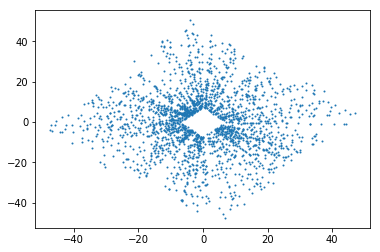

In [9]:
hits_x = [item['x'] for  key, item in VeloHits.items()]
hits_y = [item['y'] for  key, item in VeloHits.items()]
plt.plot(hits_x,hits_y, 'o', markersize=1.)

or z distribution

(array([308.,  74., 231., 397., 375., 261.,  79.,  73., 117., 189.]),
 array([-288.08099365, -184.21479492,  -80.34859619,   23.51760254,
         127.38380127,  231.25      ,  335.11619873,  438.98239746,
         542.84859619,  646.71479492,  750.58099365]),
 <a list of 10 Patch objects>)

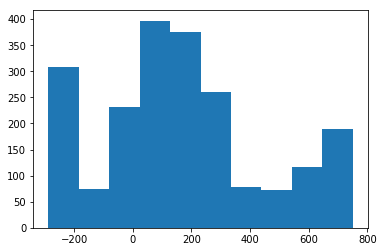

In [10]:
hits_z = [item['z'] for  key, item in VeloHits.items()]
plt.hist(hits_z)

The data is transformed from the json format to a (hopefully) more convenient form:

In [11]:
import problem

In [12]:
X, y = problem.get_train_data('.')

Rec data


X contains the training/test data, y the truth information.

In [13]:
X.shape

(6,)

In [14]:
print(X)

[EventData EventData EventData EventData EventData EventData]


There are a couple of helper classes to organize the data.
The test and train data X is a numpy array of object of type EventData. Let' have a closer look at this helper class:

In [15]:
event = X[0]

It contains the two members, hits and tracks, which are lists containing the Velo hits and states, respectively, again using helper classes:

In [16]:
event.hits[0:5]

[VeloHit(9.393913269042969, -26.134666442871094, -288.08099365234375),
 VeloHit(9.0050048828125, -24.579030990600586, -288.08099365234375),
 VeloHit(-0.38714027404785156, -14.097940444946289, -288.08099365234375),
 VeloHit(-0.38714027404785156, -13.514577865600586, -288.08099365234375),
 VeloHit(-7.1735992431640625, -16.59343719482422, -288.08099365234375)]

In [17]:
event.tracks[0:5]

[VeloState(-0.014058536488221307,-0.024329251519816353,-20.015792846679688,0.0337035171687603,-0.04416502267122269),
 VeloState(0.04143393940914564,0.03616156003867843,155.3652801513672,0.01934237591922283,-0.017269106581807137),
 VeloState(0.5647286828943905,-0.37778717743778856,92.0198745727539,0.009444397874176502,0.01475947443395853),
 VeloState(-0.01761487652828464,0.013645172620613266,67.32335662841797,-0.09499440342187881,0.05916781723499298),
 VeloState(-0.04450437906444904,0.007529980805301761,-21.103111267089844,0.09429869055747986,-0.06211370974779129)]

The VeloHit class just holds the x,y,z coordinates of the hit:

In [18]:
hit = event.hits[0]
print (hit)
print(hit.x, hit.y, hit.z)

VeloHit(9.393913269042969, -26.134666442871094, -288.08099365234375)
9.393913269042969 -26.134666442871094 -288.08099365234375


The VeloTrack helper class holds the state (x,y,z,tx,ty,p/q) of a simplified Kalman fit of the track, as well as the corresponding covariance matrix:

In [19]:
track = event.tracks[0]
print(track)
print("track state:")
print("x:", track.x)
print("y:", track.y)
print("z:", track.z)
print("tx:", track.tx)
print("ty:", track.ty)
print("pq:", track.pq)

print("covariance matrix:")
print("cov x:", track.cov_x)
print("cov y:", track.cov_y)
print("cov tx:", track.cov_tx)
print("cov ty:", track.cov_ty)
print("cov xtx:", track.cov_xtx)



VeloState(-0.014058536488221307,-0.024329251519816353,-20.015792846679688,0.0337035171687603,-0.04416502267122269)
track state:
x: -0.014058536488221307
y: -0.024329251519816353
z: -20.015792846679688
tx: 0.0337035171687603
ty: -0.04416502267122269
pq: 0.0
covariance matrix:
cov x: 0.00149062710342775
cov y: 0.00149062710342775
cov tx: 5.936173863574368e-08
cov ty: 5.936173863574368e-08
cov xtx: 8.931202236391695e-06


It should be noted that the p/q is always zero, since we have no momentum estimate from the Velo Kalman fit.
The covariance matrix consist of the diagonal elements x, y, tx, ty and the off-diagonal element xtx. The Velo Kalman fit contains some simplifications, resulting that the covariance element for x and y is always equal. The same is true for the xtx and yty elements

Again, we can make plots:

In [20]:
hits_x = [hit.x for hit in event.hits]
hits_y = [hit.y for hit in event.hits]
hits_z = [hit.z for hit in event.hits]

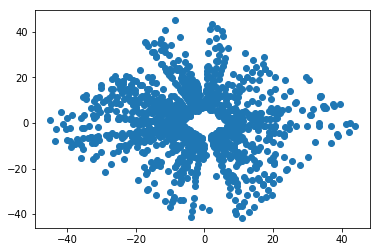

In [21]:
plt.plot(hits_x, hits_y, 'o')

(array([188.,  38., 125., 186., 201., 174.,  51.,  52.,  83., 114.]),
 array([-288.08099365, -184.21479492,  -80.34859619,   23.51760254,
         127.38380127,  231.25      ,  335.11619873,  438.98239746,
         542.84859619,  646.71479492,  750.58099365]),
 <a list of 10 Patch objects>)

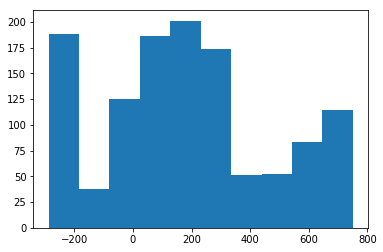

In [22]:
plt.hist(hits_z)